In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from implementations import *
from utilitaries import *

Data Cleaning
===

In [72]:
from proj1_helpers import *

labels, features, indices = load_csv_data('../Data/train.csv', sub_sample=False)
# b(background) -> -1 and s(signal) -> 1

n_samples, n_features = np.shape(features)
features = remove_meaningless_data(features)
std_features = standardize(features)

print(n_samples, n_features)

250000 30


In [84]:
prop_nan = np.zeros((2,30))

for i in range(n_features):
    n_nan = 0
    for j in range(n_samples):
        if np.isnan(std_features[j,i]):
            n_nan += 1
    prop_nan[0,i] = i
    prop_nan[1,i] = n_nan/n_samples

print(prop_nan)

[[ 0.        1.        2.        3.        4.        5.        6.
   7.        8.        9.       10.       11.       12.       13.
  14.       15.       16.       17.       18.       19.       20.
  21.       22.       23.       24.       25.       26.       27.
  28.       29.      ]
 [ 0.152456  0.        0.        0.        0.709828  0.709828  0.709828
   0.        0.        0.        0.        0.        0.709828  0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.399652  0.399652  0.399652  0.709828  0.709828
   0.709828  0.      ]]


Features selection
===

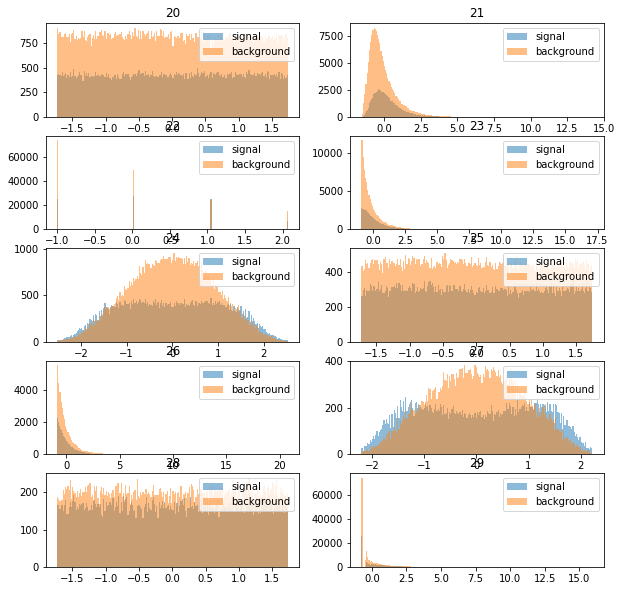

In [81]:
plt.figure(figsize=(10,10))

pics = 200

for i in range(10):
    plt.subplot(5,2,i+1)
    plt.hist(std_features[labels == 1,20+i][~np.isnan(features[labels == 1,20+i])], pics, alpha=0.5, label='signal')
    plt.hist(std_features[labels == -1,20+i][~np.isnan(features[labels == -1,20+i])], pics, alpha=0.5, label='background')
    plt.legend(loc='upper right')
    plt.title(20+i)
    
plt.show()